# Verification of transfer coefficients and melt rate calculation

Focusing on MITgcm BAS models.

Looks like $\Gamma_T = 0.0135$ fits with the MITgcm-BAS-Coupled runs so that value has been updated.

$\Gamma_T = 0.011$ fits with the Ocean1 MITgcm-BAS run, but not Ocean2.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm
from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

from matplotlib import gridspec

In [2]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)

def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


In [3]:
#12 model colours for 12 models, generated using https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=12
modelcolours=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']


In [12]:
# Constants

rho_fw = 1000 #kg/m3
L = 3.34e5 #J/kg
rho_sw = 1028 #kg/m3
Cw = 3974

GammaT={'COCO':2.5e-2,
'FVCOM':.2,
'MITgcm-BAS':1.1e-2,
'MITgcm-BAS-Coupled':1.35e-2,
'MITgcm-JPL':3.25e-2,
'MOM6-LAYER':1.4e-1,
'MOM6-SIGMA-ZSTAR':4.5e-2,
'MPAS-Ocean':1.94e-2,
'NEMO-CNRS':2.6e-2,
'NEMO-UKESM1is':4.5e-2,
'POP2x':1.146e-1,
'ROMS':5e-2}

Text(0.01, 0.99, 'b')

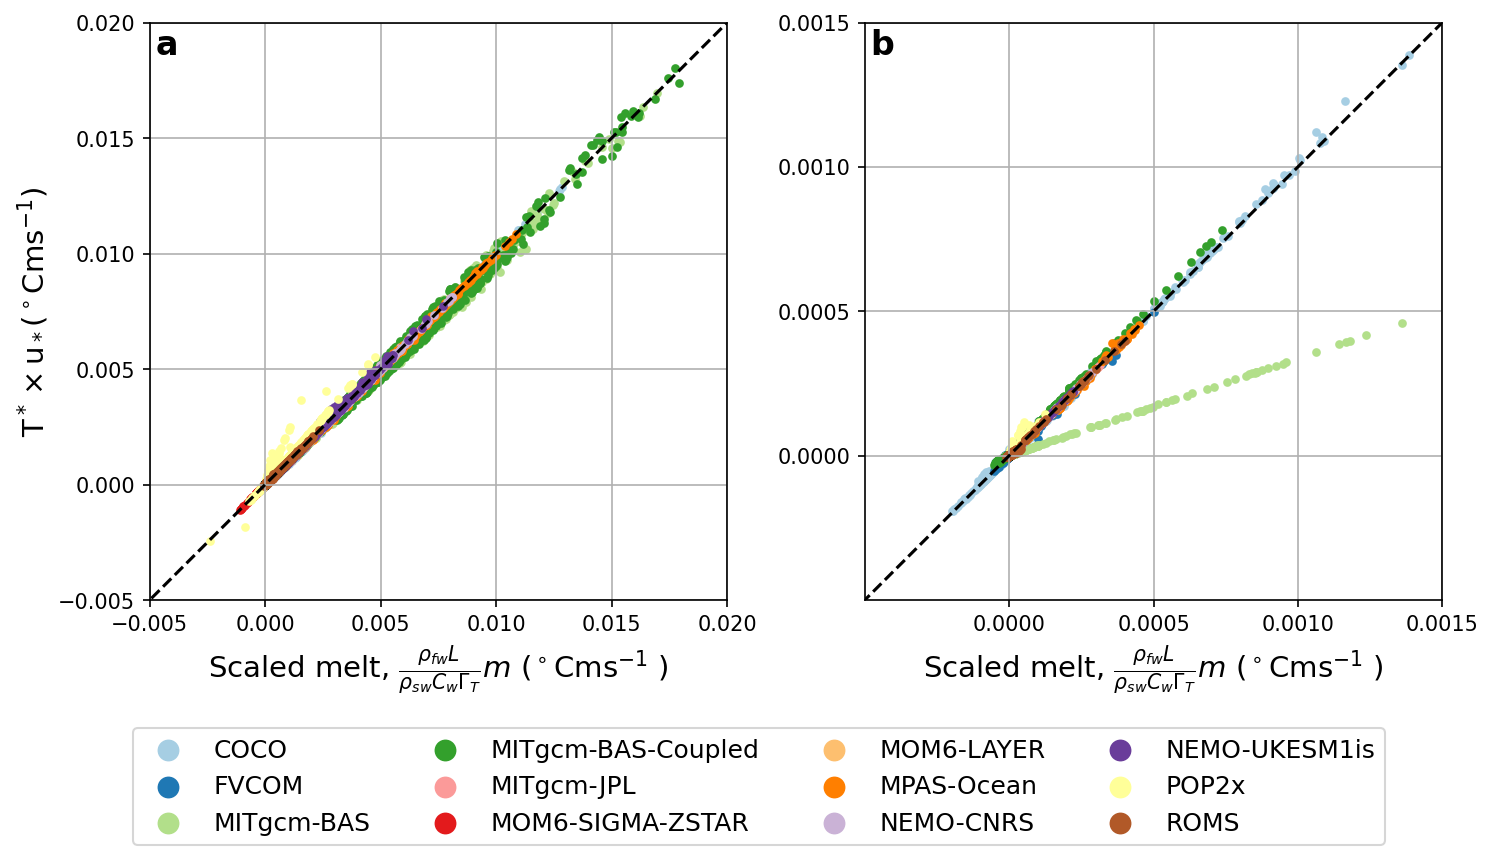

In [13]:
# scatter plot of melt rates aganst T^* and u_* for Ocean1_COM and Ocean2_COM

# takes mean(u*T*) not mean(u*)mean(T*) but there isn't much difference.

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.15, hspace=0.05)
fig = plt.figure(figsize=(11.5,5),facecolor='w',dpi = 150)


expt = Ocean1_COM
labels = get_labels(expt)

length = len(expt)

# scatter plot of melt rates divided by constants aganst T^* times u_* for Ocean1_COM

ax=fig.add_subplot(gs[0])

for i in np.arange(length):

    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    time = len(data.nTime)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    melt_av = (melt.where(melt<1e36))
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar_av = (tstar.where(tstar<1e36)).where(melt!=0)
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)
    melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)
    ax.scatter(melt_div_constants, tstar_av*ustar_av,s=10,color=modelcolours[i])
    ax.scatter(melt_div_constants[-1], tstar_av[-1]*ustar_av[-1], s=10,label=labels[i],color=modelcolours[i])
    
ax.plot((-0.01,0.02),(-0.01,.02),'k--')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),frameon=False,ncol=length/2,handletextpad=0.01)
ax.legend(fontsize=12, ncol = 4, loc = 'upper left', bbox_to_anchor = (-0.05,-0.2),markerscale=3.)

ax.set_xlim((-.005,0.02))
ax.set_ylim((-.005,0.02))
ax.set_aspect('equal')
ax.grid()
plt.xlabel(r'Scaled melt, $\frac{\rho_{fw}L}{\rho_{sw}C_w\Gamma_T}m$ ($^\circ$Cms$^{-1}$ )',fontsize=14)
plt.ylabel(r'$\mathrm{T^*\times u_* (^\circ C ms^{-1} )}$',fontsize=14)
plt.text(0.01,0.99,'a', fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')

### Ocean2

expt = Ocean2_COM
labels = get_labels(expt)

length = len(expt)

# scatter plot of melt rates divided by constants aganst T^* times u_* for Ocean1_COM

ax=fig.add_subplot(gs[1])

for i in np.arange(length):

    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    time = len(data.nTime)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    melt_av = (melt.where(melt<1e36))
    tstar = data.thermalDriving#.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar_av = (tstar.where(tstar<1e36)).where(melt!=0) # this is needed for MOM6 SIGMAZSTAR which is thermal driving in palces with zero melt
    ustar = data.frictionVelocity#.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)
    melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)
    ax.scatter(melt_div_constants, (tstar_av*ustar_av).isel(nTime = np.arange(time-13,time)).mean('nTime'),s=10,color=modelcolours[i])
    ax.scatter(melt_div_constants[-1], (tstar_av*ustar_av).isel(nTime = np.arange(time-13,time)).mean('nTime')[-1], s=10,label=labels[i],color=modelcolours[i])
    
ax.plot((-0.02,0.02),(-0.02,.02),'k--')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),frameon=False,ncol=length/2,handletextpad=0.01)
#ax.legend(loc='lower right',frameon=False,handletextpad=0.01)

ax.set_xlim((-.0005,0.0015))
ax.set_ylim((-.0005,0.0015))
ax.set_yticks([0,0.0005,0.001,0.0015])
ax.set_xticks([0,0.0005,0.001,0.0015])
ax.set_aspect('equal')
ax.grid()
plt.xlabel(r'Scaled melt, $\frac{\rho_{fw}L}{\rho_{sw}C_w\Gamma_T}m$ ($^\circ$Cms$^{-1}$ )',fontsize=14)
#plt.ylabel(r'$\mathrm{T^*\times u_* (^\circ C  ms^{-1} )}$',fontsize=14)
plt.text(0.01,0.99,'b', fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')


# Just MITgcm-BAS results

expt file = MITgcm-BAS/Ocean0-2 COM/Ocean1_COM_MITgcm_BAS.nc
model label = MITgcm-BAS
tranfer coeff = 0.011
expt file = MITgcm_BAS_Coupled/Ocean0-2 COM/Ocean1_COM_MITgcm_BAS_CoupledV3.nc
model label = MITgcm-BAS-Coupled
tranfer coeff = 0.0135
expt file = MITgcm-BAS/Ocean0-2 COM/Ocean2_COM_MITgcm_BAS.nc
model label = MITgcm-BAS
tranfer coeff = 0.011
expt file = MITgcm_BAS_Coupled/Ocean0-2 COM/Ocean2_COM_MITgcm_BAS_CoupledV3.nc
model label = MITgcm-BAS-Coupled
tranfer coeff = 0.0135


Text(0.01, 0.99, 'b')

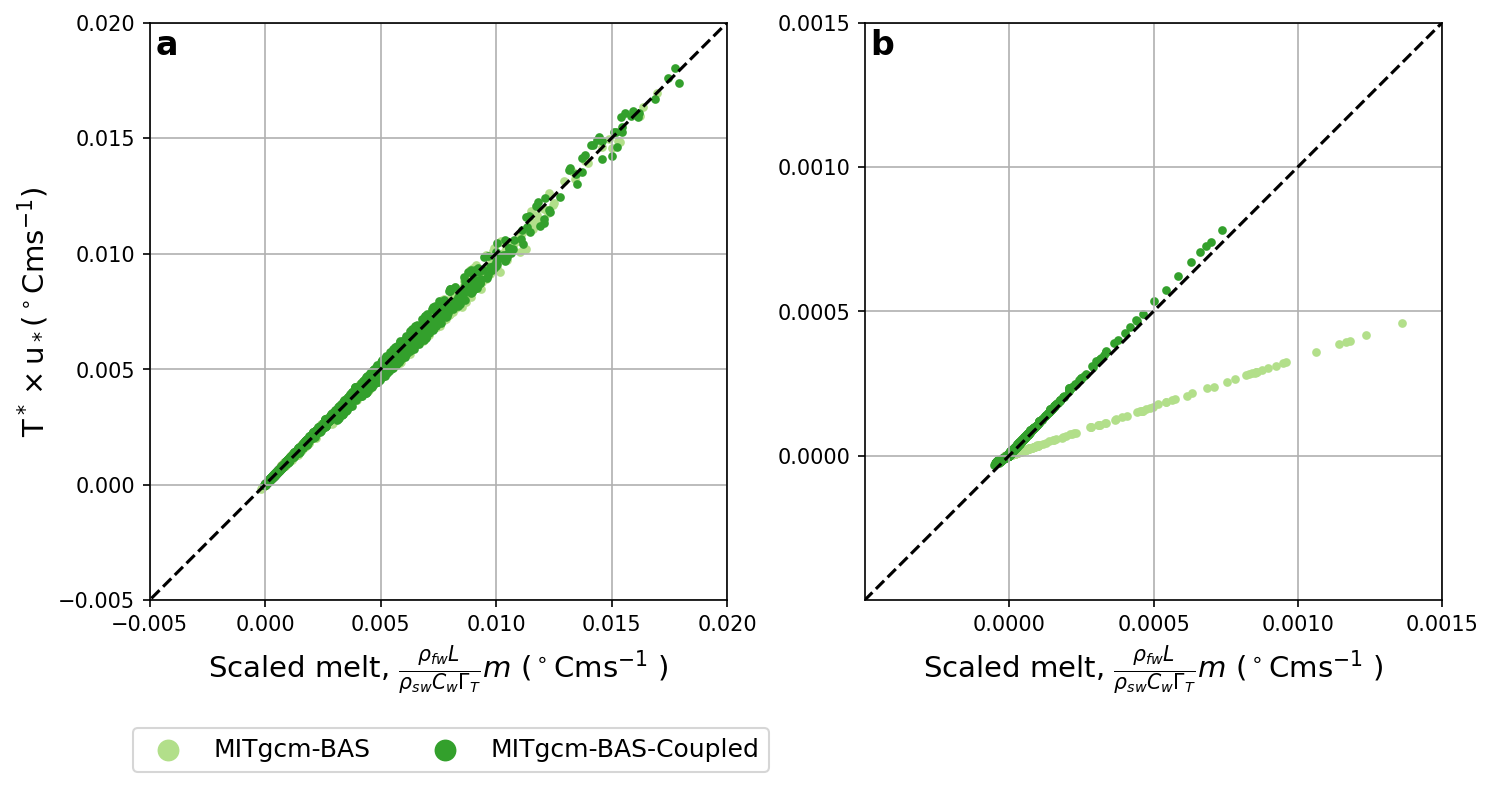

In [19]:
# scatter plot of melt rates aganst T^* and u_* for Ocean1_COM and Ocean2_COM

# takes mean(u*T*) not mean(u*)mean(T*) but there isn't much difference.

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.15, hspace=0.05)
fig = plt.figure(figsize=(11.5,5),facecolor='w',dpi = 150)


expt = Ocean1_COM
labels = get_labels(expt)

length = len(expt)

# scatter plot of melt rates divided by constants aganst T^* times u_* for Ocean1_COM

ax=fig.add_subplot(gs[0])

for i in np.array([2,3]):
    print('expt file = '+expt[i])
    print('model label = '+labels[i])
    print('tranfer coeff = '+str(GammaT[labels[i]]))
    
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    time = len(data.nTime)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    melt_av = (melt.where(melt<1e36)).where(melt!=0)
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar_av = (tstar.where(tstar<1e36)).where(melt!=0)
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)
    melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)
    ax.scatter(melt_div_constants, tstar_av*ustar_av,s=10,color=modelcolours[i])
    ax.scatter(melt_div_constants[-1], tstar_av[-1]*ustar_av[-1], s=10,label=labels[i],color=modelcolours[i])
    
ax.plot((-0.01,0.02),(-0.01,.02),'k--')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),frameon=False,ncol=length/2,handletextpad=0.01)
ax.legend(fontsize=12, ncol = 4, loc = 'upper left', bbox_to_anchor = (-0.05,-0.2),markerscale=3.)

ax.set_xlim((-.005,0.02))
ax.set_ylim((-.005,0.02))
ax.set_aspect('equal')
ax.grid()
plt.xlabel(r'Scaled melt, $\frac{\rho_{fw}L}{\rho_{sw}C_w\Gamma_T}m$ ($^\circ$Cms$^{-1}$ )',fontsize=14)
plt.ylabel(r'$\mathrm{T^*\times u_* (^\circ C ms^{-1} )}$',fontsize=14)
plt.text(0.01,0.99,'a', fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')

### Ocean2

expt = Ocean2_COM
labels = get_labels(expt)

length = len(expt)

# scatter plot of melt rates divided by constants aganst T^* times u_* for Ocean1_COM

ax=fig.add_subplot(gs[1])

for i in np.array([2,3]):
    print('expt file = '+expt[i])
    print('model label = '+labels[i])
    print('tranfer coeff = '+str(GammaT[labels[i]]))
    
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    time = len(data.nTime)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    melt_av = (melt.where(melt<1e36)).where(melt!=0)
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar_av = (tstar.where(tstar<1e36)).where(melt!=0)
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)
    melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)
    ax.scatter(melt_div_constants, tstar_av*ustar_av,s=10,color=modelcolours[i])
    ax.scatter(melt_div_constants[-1], tstar_av[-1]*ustar_av[-1], s=10,label=labels[i],color=modelcolours[i])

ax.plot((-0.02,0.02),(-0.02,.02),'k--')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),frameon=False,ncol=length/2,handletextpad=0.01)
#ax.legend(loc='lower right',frameon=False,handletextpad=0.01)

ax.set_xlim((-.0005,0.0015))
ax.set_ylim((-.0005,0.0015))
ax.set_yticks([0,0.0005,0.001,0.0015])
ax.set_xticks([0,0.0005,0.001,0.0015])
ax.set_aspect('equal')
ax.grid()
plt.xlabel(r'Scaled melt, $\frac{\rho_{fw}L}{\rho_{sw}C_w\Gamma_T}m$ ($^\circ$Cms$^{-1}$ )',fontsize=14)
#plt.ylabel(r'$\mathrm{T^*\times u_* (^\circ C  ms^{-1} )}$',fontsize=14)
plt.text(0.01,0.99,'b', fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')


# Determine $\Gamma_T$ for Ocean2 MITgcm-BAS from Line of best fit

expt file = MITgcm-BAS/Ocean0-2 COM/Ocean2_COM_MITgcm_BAS.nc
model label = MITgcm-BAS
input tranfer coeff = 0.011
solution: y = 2.9640680744625696x-2.0448040133582767e-06
actual gamma derived from plot = 2.9640680744625696 x 0.011 = 0.032604748819088265


Text(0, 0.5, '$\\mathrm{T^*\\times u_* (^\\circ C ms^{-1} )}$')

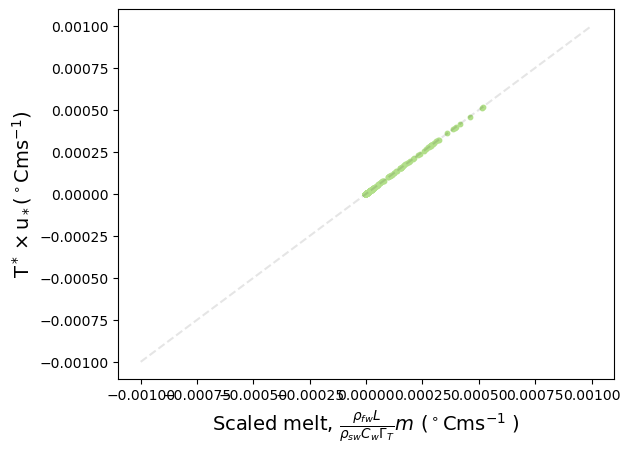

In [43]:
expt = Ocean2_COM
labels = get_labels(expt)

# open MITgcm-BAS data
i = 2
print('expt file = '+expt[i])
print('model label = '+labels[i])
print('input tranfer coeff = '+str(GammaT[labels[i]]))

data = xr.open_dataset(basedrive+expt[i], decode_times=False)
time = len(data.nTime)
melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
melt_av = (melt.where(melt<1e36)).where(melt!=0)
tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
tstar_av = (tstar.where(tstar<1e36)).where(melt!=0)
ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)

melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)

# use polyfit to fit the line
p = np.polyfit(np.ravel((tstar_av*ustar_av).fillna(0)), np.ravel(melt_div_constants.fillna(0)), 1)
print('solution: y = '+str(p[0])+'x'+str(p[1]))
print('actual gamma derived from plot = '+str(p[0])+' x 0.011 = '+str(p[0]*GammaT[labels[i]]))

# plot with updated gamma to check

Gamma_T_test = p[0]*GammaT[labels[i]]
melt_div_constants = melt_av*rho_fw*L/(rho_sw*Gamma_T_test*Cw)

plt.plot((-0.001,0.001),(-0.001,.001),'k--',alpha = 0.1)
plt.scatter(melt_div_constants, tstar_av*ustar_av,s=10,color=modelcolours[i])
plt.xlabel(r'Scaled melt, $\frac{\rho_{fw}L}{\rho_{sw}C_w\Gamma_T}m$ ($^\circ$Cms$^{-1}$ )',fontsize=14)
plt.ylabel(r'$\mathrm{T^*\times u_* (^\circ C ms^{-1} )}$',fontsize=14)


expt file = MITgcm-BAS/Ocean0-2 COM/Ocean2_COM_MITgcm_BAS.nc
model label = MITgcm-BAS
input tranfer coeff = 0.011
solution: y = 3.2388436859524132x-4.644578572911255e-06
actual gamma derived from plot = 3.2388436859524132 x 0.011 = 0.03562728054547654


Text(0, 0.5, '$\\mathrm{T^*\\times u_* (^\\circ C ms^{-1} )}$')

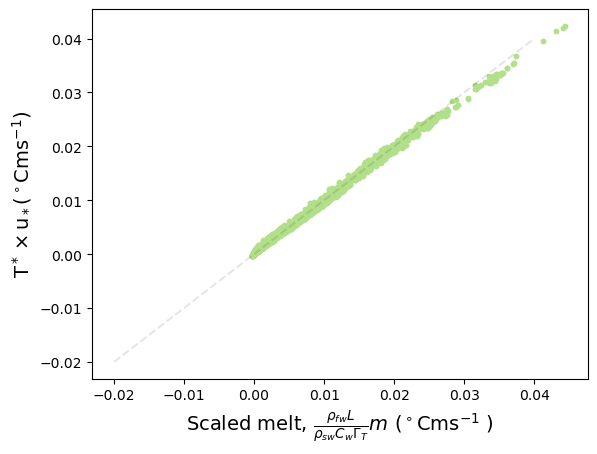

In [52]:
# Repeat without averaging over time

expt = Ocean2_COM
labels = get_labels(expt)

# open MITgcm-BAS data
i = 2
#check it's the right file
print('expt file = '+expt[i])
print('model label = '+labels[i])
print('input tranfer coeff = '+str(GammaT[labels[i]]))

data = xr.open_dataset(basedrive+expt[i], decode_times=False)
time = len(data.nTime)
melt = (data.meltRate)#.isel(nTime = np.arange(0,12))#.mean('nTime')
melt_av = (melt.where(melt<1e36)).where(melt!=0)
tstar = data.thermalDriving#.isel(nTime = np.arange(0,12))#.mean('nTime')
tstar_av = (tstar.where(tstar<1e36)).where(melt!=0)
ustar = data.frictionVelocity#.isel(nTime = np.arange(0,12))#.mean('nTime')
ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)

melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)

# use polyfit to fit the line
p = np.polyfit(np.ravel((tstar_av*ustar_av).fillna(0)), np.ravel(melt_div_constants.fillna(0)), 1)
print('solution: y = '+str(p[0])+'x'+str(p[1]))
print('actual gamma derived from plot = '+str(p[0])+' x 0.011 = '+str(p[0]*GammaT[labels[i]]))

# plot with updated gamma to check

Gamma_T_test = p[0]*GammaT[labels[i]]
melt_div_constants = melt_av*rho_fw*L/(rho_sw*Gamma_T_test*Cw)

plt.plot((-0.02,0.04),(-0.02,.04),'k--',alpha = 0.1)
plt.scatter(melt_div_constants, tstar_av*ustar_av,s=10,color=modelcolours[i])
plt.xlabel(r'Scaled melt, $\frac{\rho_{fw}L}{\rho_{sw}C_w\Gamma_T}m$ ($^\circ$Cms$^{-1}$ )',fontsize=14)
plt.ylabel(r'$\mathrm{T^*\times u_* (^\circ C ms^{-1} )}$',fontsize=14)


# Open up files and have a look

/g/data/x77/cy8964/ISOMIP+Data-new/MITgcm-BAS/Ocean0-2 COM/Ocean1_COM_MITgcm_BAS.nc


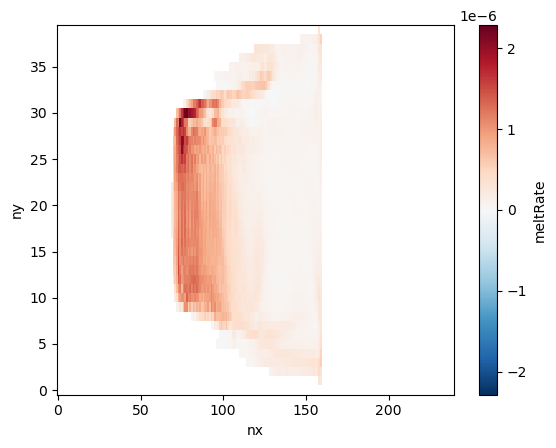

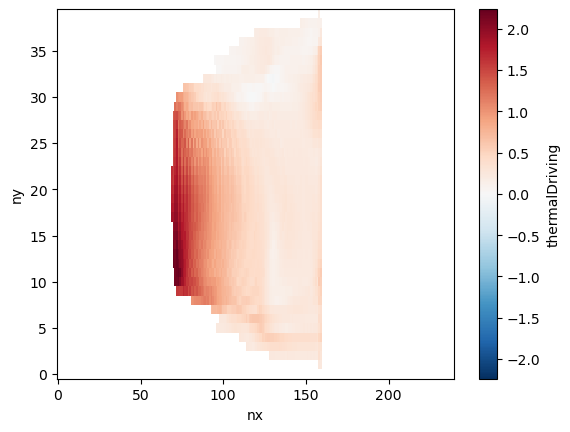

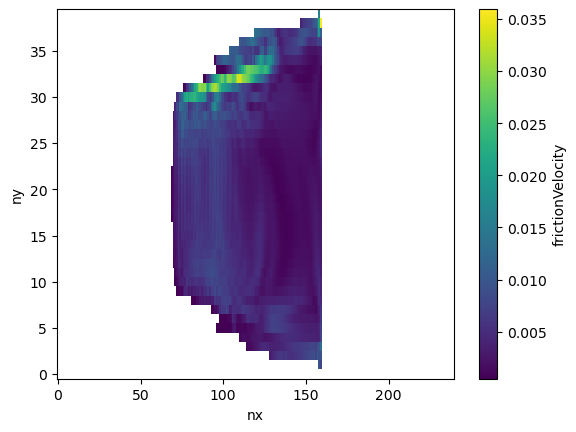

In [40]:
expt = Ocean1_COM
labels = get_labels(expt)

# open MITgcm-BAS data
i = 2
print(basedrive+expt[i])
data = xr.open_dataset(basedrive+expt[i], decode_times=False)
time = len(data.nTime)
melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
melt_av = (melt.where(melt<1e36)).where(melt!=0)
tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
tstar_av = (tstar.where(tstar<1e36)).where(melt!=0)
ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)

melt_av.plot()
plt.show()
tstar_av.plot()
plt.show()
ustar_av.plot()

/g/data/x77/cy8964/ISOMIP+Data-new/MITgcm-BAS/Ocean0-2 COM/Ocean2_COM_MITgcm_BAS.nc


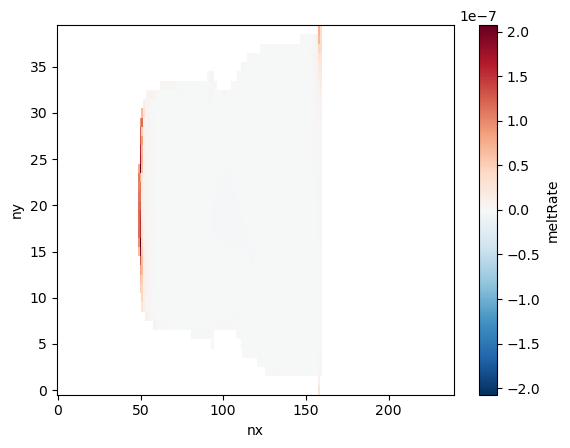

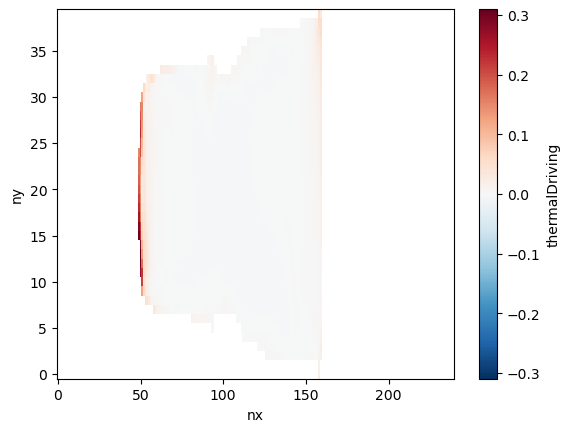

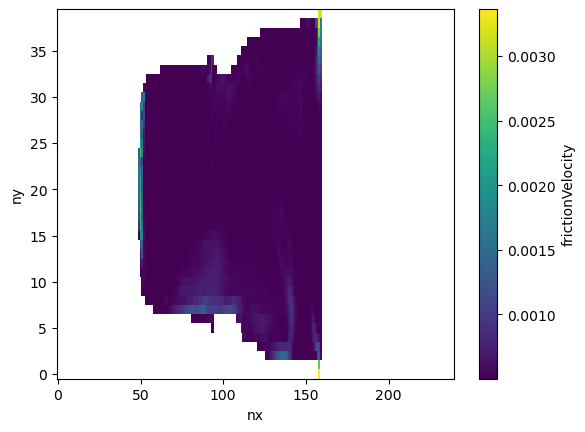

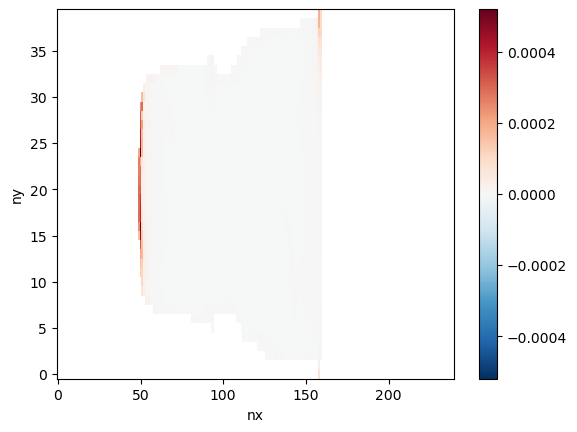

In [41]:
expt = Ocean2_COM
labels = get_labels(expt)

# open MITgcm-BAS data
i = 2
data = xr.open_dataset(basedrive+expt[i], decode_times=False)
print(basedrive+expt[i])
time = len(data.nTime)
melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
melt_av = (melt.where(melt<1e36)).where(melt!=0)
tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
tstar_av = (tstar.where(tstar<1e36)).where(melt!=0)
ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)

melt_av.plot()
plt.show()
tstar_av.plot()
plt.show()
ustar_av.plot()
plt.show()
(tstar_av*ustar_av).plot()


/g/data/x77/cy8964/ISOMIP+Data-new/MITgcm-JPL/Ocean0-2 COM/Ocean2_COM_MITgcm_JPL.nc


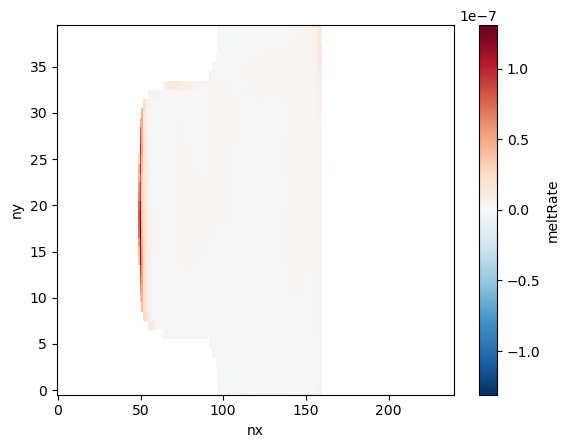

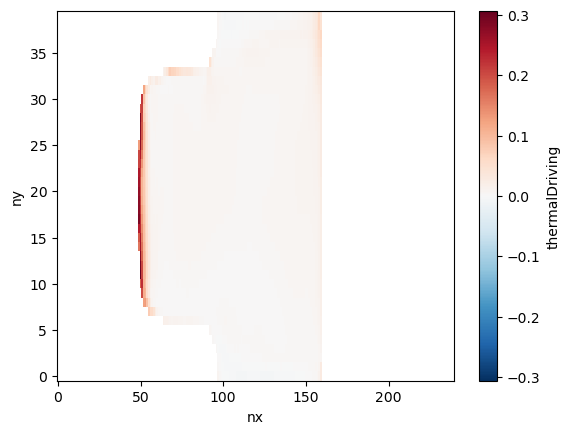

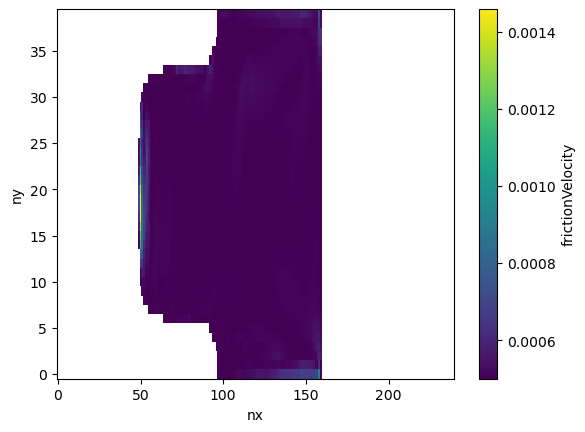

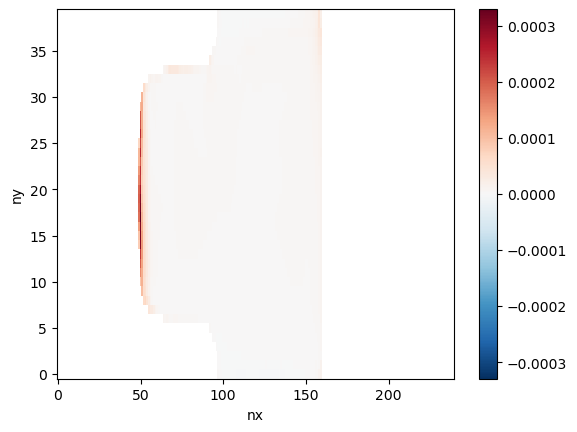

In [42]:
expt = Ocean2_COM
labels = get_labels(expt)

# open MITgcm-JPL data
i = 4
data = xr.open_dataset(basedrive+expt[i], decode_times=False)
print(basedrive+expt[i])
time = len(data.nTime)
melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
melt_av = (melt.where(melt<1e36)).where(melt!=0)
tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
tstar_av = (tstar.where(tstar<1e36)).where(melt!=0)
ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
ustar_av = (ustar.where(ustar<1e36)).where(melt!=0)

melt_av.plot()
plt.show()
tstar_av.plot()
plt.show()
ustar_av.plot()
plt.show()
(tstar_av*ustar_av).plot()


### (Verifying that MITgcm JPL and MITgcm BAS look sufficiently different that there was no cross-contamination of netcdf files)